In [1]:
%matplotlib inline
import waves
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

plt.rcParams['font.size'] = 14

A/D conversion
=============

In [2]:
CD = waves.CDFormatSampler('CD')

SACD = waves.DSDSampler('SACD', 64 * 44100, 16)

# DVD possible combinations (16-, 20- or 24-bits per sample)
# Channels                          | 44.1 kHz | 48 kHz | 88.2 kHz | 96 kHz | 176.4 kHz | 192 kHz
# Mono (1.0)                        |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.0)                      |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.1)                      |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# S+M surround (3.0 or 3.1)         |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Quad (4.0 or 4.1)                 |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo (3.0 or 3.1)             |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo+M surround (4.0 or 4.1)  |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Full surround (5.0 or 5.1)        |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
DVDA = waves.PCMSampler('DVD Audio', 88200, 20)

# High Fidelity Blu-ray Pure Audio uses 24 bits at 192 kHz (or also 96 kHz)
BDA = waves.HFPALinearPCM('Blu-Ray Audio')

# Generic, define sampling frequency (Hz) and resolution (bits) to your heart's content
GenericPCM_1 = waves.PCMSampler('PCM 1', 44100, 20) # Same CD frequency, lower resolution
GenericPCM_2 = waves.PCMSampler('PCM 2', 14000, 16) # Same CD resolution, lower frequency

In [3]:
ADC_list = [GenericPCM_1, GenericPCM_2]
dither_setup = {
    'nodither': {
        'label': 'Without dither',
        'c': 'C1',
        'w': 3,
    },
    'dither': {
        'label': 'With dither',
        'c': 'C0',
        'w': 1,
    },
}

In [4]:
f = 1.2e3 # in Hertz, i.e., 1.2 KHz
audio = waves.AnalogSineWave('analog', f, gain=1, phase=0, infinity=600)
n_waves = 4
length = n_waves * 1/f # in seconds

Let us see how the noise behaves without and with dither added:

PCM 1's stream without dither (1048576 levels): [524288 598622 670790 738685 ... 248246 309890 377785 449953]
PCM 2's stream without dither (65536 levels): [32767 46773 56813 60046 ... 7659 5708 11419 23173]
PCM 1's stream with dither (1048576 levels): [524288 598622 670790 738685 ... 248246 309890 377785 449953]
PCM 2's stream with dither (65536 levels): [32767 46773 56813 60046 ... 7659 5708 11419 23173]


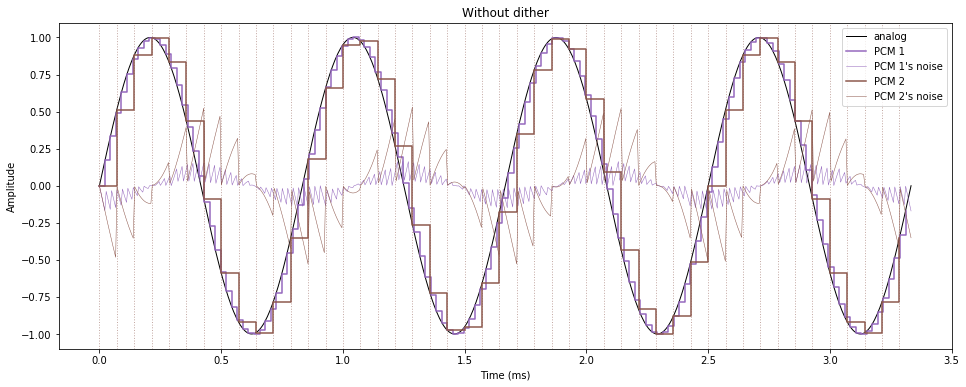

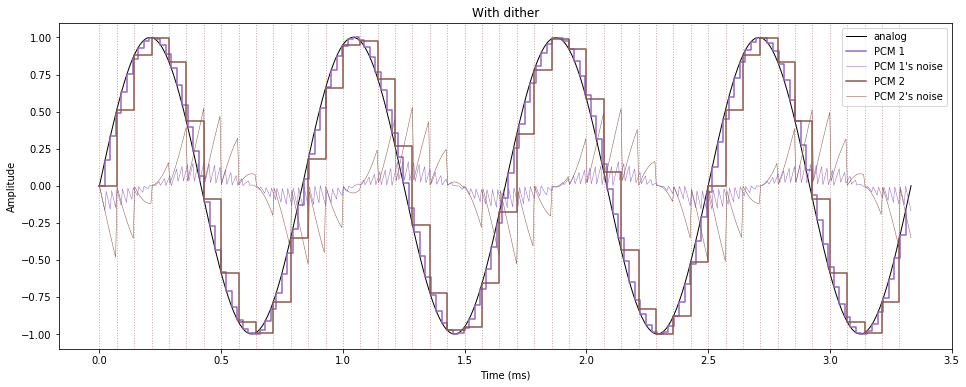

In [31]:
digi_signal = {}
noise_signal = dict([(k, {}) for k in dither_setup.keys()])

for dithering, setup in dither_setup.items():
    fig, ax = plt.subplots()
    digi_signal[dithering] = dict([(ADC.label, {}) for ADC in ADC_list])
    noise_signal[dithering]['time_domain'] = audio.plot(length, plt, color='k', lw=1)
    for ADC in ADC_list:
        unsigned, digi_signal[dithering][ADC.label]['time_domain'], digi_signal[dithering][ADC.label]['signal'], _, noise_signal[dither][ADC.label] = ADC.sample(audio, length, ax, lw=1.5)
        print(waves.of(ADC.label), 'stream', setup['label'].lower(), 
              '(%i levels):' % ADC.levels, waves.shortlist(unsigned)
             )
        
    # Show grid of ADC with the lowest sampling frequency:
    ADC = sorted(ADC_list, key=lambda ADC: ADC.sampling_frequency)[0]
    [ax.axvline(t*1000, color=ADC.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, ADC.sampling_interval)]
    
    # Show grid of ADC with the lowest resolution:
    ADC = sorted(ADC_list, key=lambda ADC: ADC.amplitude_resolution)[0]
    # but only if no more than 4-bit, since too many levels
    if ADC.amplitude_resolution <= 4:
        [ax.axhline(A, color=ADC.color, lw=1, ls=':', alpha=0.5) for A in np.linspace(ADC.amp_min, ADC.amp_max, ADC.levels)]
    
    ax.legend()
    ax.set_title(setup['label'])
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time (ms)')
    fig.set_size_inches(16, 6)

The noise is more decorrelated from the signal when dither is added. However, this comes at the cost of increased noise power:

In [29]:
def show_noise_signal_correlation(signal, dither_setup, noises, ADC):
    fig, ax = plt.subplots(1, 2)
    for dithering, setup in dither_setup.items():
        analog = signal.function(noises[dithering]['time_domain'])
        ax[0].scatter(analog, noises[dithering][ADC.label], color=setup['c'], label=setup['label'])
        ax[1].plot(*waves.twopar_correlation(noises[dithering][ADC.label], analog), color=setup['c'], lw=setup['w'], label=setup['label'])
    ax[0].legend()
    ax[0].set_xlabel('Signal amplitude')
    ax[0].set_ylabel('Noise amplitude')
    ax[1].set_ylim(-1, 1)
    ax[1].grid(alpha=0.5)
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Signal-noise correlation')
    ax[1].legend()
    fig.suptitle(ADC.label)
    fig.set_size_inches(16, 6)

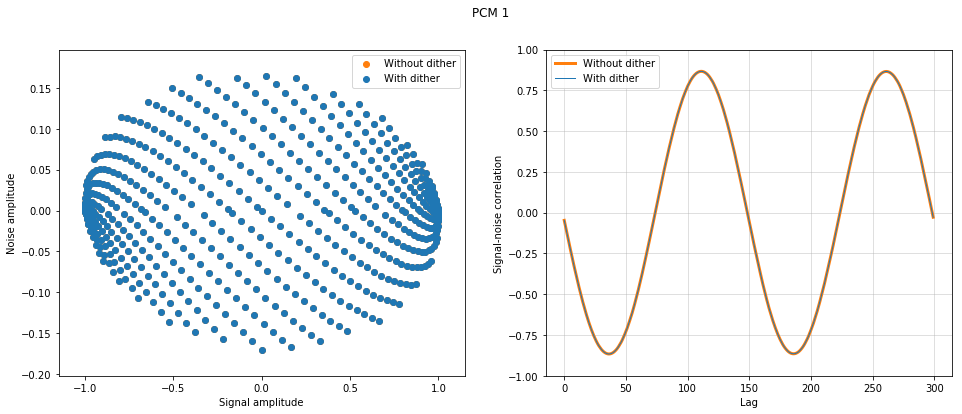

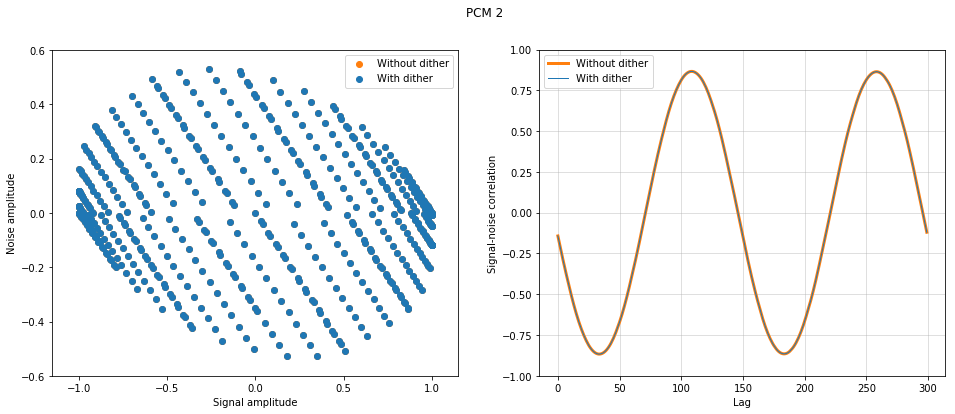

In [30]:
for ADC in ADC_list:
    show_noise_signal_correlation(audio, dither_setup, noise_signal, ADC)

PCM 2 is unaffected, probably because of the high resolution, but for PCM 1 we can see that the correlation is reduced although the noise amplitude has enhanced.

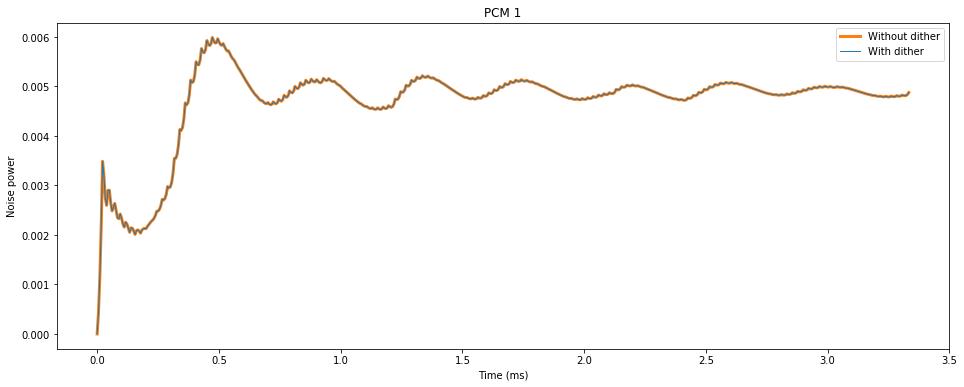

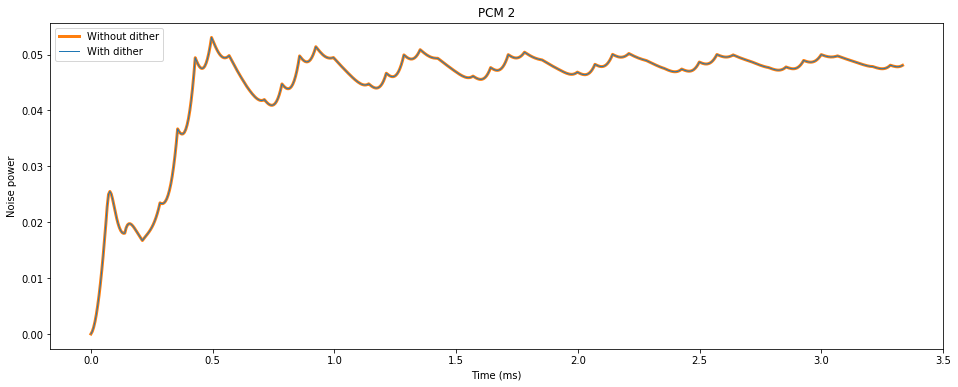

In [26]:
for ADC in ADC_list:
    fig, ax = plt.subplots()
    for dithering, setup in dither_setup.items():
        ax.plot(noise_signal[dithering]['time_domain']*1000, 
                [st.moment(noise_signal[dithering][ADC.label][:t+1], moment=2) for t in range(len(noise_signal[dither]['time_domain']))], 
                color=setup['c'], lw=setup['w'], label=setup['label'])
        ax.set_title(ADC.label)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Noise power')
        ax.legend()
        fig.set_size_inches(16, 6)

Here we can also see, for PCM 1, that the introduction of dither enhanced the total noise power.
Let us also have a look at the Fourier transform of the signals.

In [16]:
from scipy.fftpack import rfft, rfftfreq, fftshift

In [17]:
rfftfreq(148, d=GenericPCM_1.sampling_interval)[1::2]

array([  297.97297297,   595.94594595,   893.91891892,  1191.89189189,
        1489.86486486,  1787.83783784,  2085.81081081,  2383.78378378,
        2681.75675676,  2979.72972973,  3277.7027027 ,  3575.67567568,
        3873.64864865,  4171.62162162,  4469.59459459,  4767.56756757,
        5065.54054054,  5363.51351351,  5661.48648649,  5959.45945946,
        6257.43243243,  6555.40540541,  6853.37837838,  7151.35135135,
        7449.32432432,  7747.2972973 ,  8045.27027027,  8343.24324324,
        8641.21621622,  8939.18918919,  9237.16216216,  9535.13513514,
        9833.10810811, 10131.08108108, 10429.05405405, 10727.02702703,
       11025.        , 11322.97297297, 11620.94594595, 11918.91891892,
       12216.89189189, 12514.86486486, 12812.83783784, 13110.81081081,
       13408.78378378, 13706.75675676, 14004.72972973, 14302.7027027 ,
       14600.67567568, 14898.64864865, 15196.62162162, 15494.59459459,
       15792.56756757, 16090.54054054, 16388.51351351, 16686.48648649,
      

In [24]:
def fourier(dither_setup, digi_signal, ADC):
    style = iter([('C1', 3), ('C0', 1)])
    fig, ax = plt.subplots()
    for dithering, setup in dither_setup.items():
        t = digi_signal[dithering][ADC.label]['time_domain']
        yf = rfft(digi_signal[dithering][ADC.label]['signal'])
        tf = rfftfreq(digi_signal[dithering][ADC.label]['time_domain'].size, d=ADC.sampling_interval)
        c, w = next(style)
        #print(list(zip(tf, yf)))
        #print(list(zip(tf[1::2], yf[1::2])))
        ax.vlines(tf[1::2]/1000, 0, np.abs(yf[1::2]), color=setup['c'], lw=setup['w'], label=setup['label'])
        #plt.plot(tf[1::2]/1000, np.abs(yf[1::2]), lw=1, label=label)
    ax.legend()
    #ax.set_xscale('log')
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Amplitude')
    ax.set_title(ADC.label)
    ax.grid(which='both', alpha=0.5)
    fig.set_size_inches(16, 6)

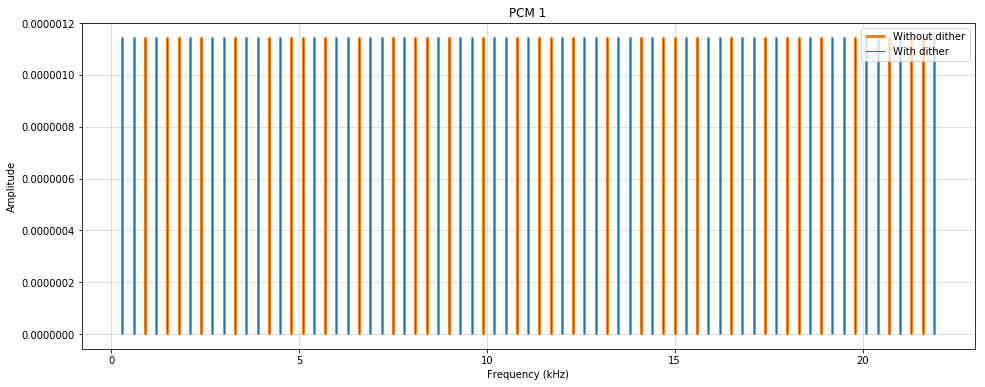

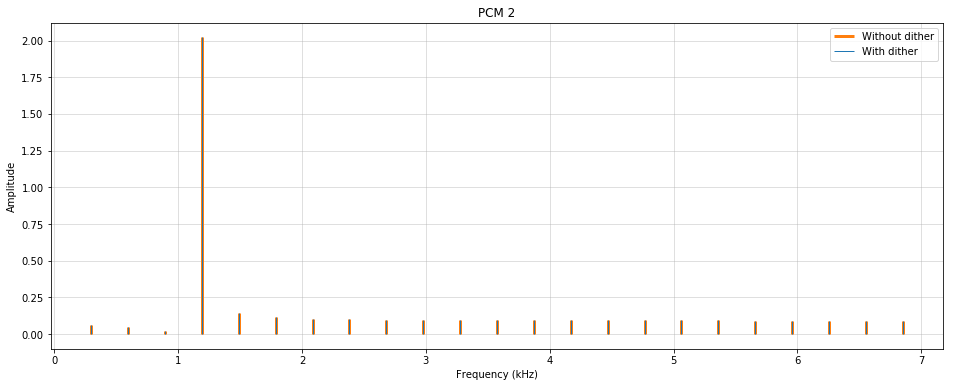

In [25]:
for ADC in ADC_list:
    fourier(dither_setup, digi_signal, ADC)